# COURSERA DATA SCIENCE PROFESSIONAL CERTIFICATE
### CAPSTONE PROJECT - The battle of Neighborhoods

## Table of Contents

1. [Problem Description](#intro)


2. [Data](#Data)

    2.1 [Introduction: Data description](#data_intro)

    2.2 [Load modules](#Load_modules)

    2.3 [Load and prepare income data by postal code](#Load_income)

    2.4 [Load and prepare geographical data](#Load_geo)

    2.5 [Merge income and geographical data](#Merge_income_geo)

    2.6 [Retreive venue data by postal code](#Venues)
    
3.  [Methodology and Data analysis](#Analysis)

    3.1 [Data preparation](#Data_prep)
    
    3.2 [Preliminary Analysis: Income and venues](#An_Inc)
    
    3.3 [Neighborhoods ratings](#Neighborhoos_ratings)
    
4.   [Results](#Viz)

5.  [Discussion](#discussion)

6.  [Conclusion](#conclusion)

## Problem Description <a class="anchor" id="intro"></a>

We will consider the problem of finding an optimal location for a new Coffee Shop in the city of Toronto.

We will need to find an appropriate location for the owner of a future new Coffee Shopp. Finding a suitable location if of paramount importance, as it is one of the most important element to ensure the economic viability of the project. This is even more important ina  big city like Toronto, where there could be a big demand, but also a lot of competition for costumers.

Upon discussion with the owner, we identified the characteristics of an interesting location. Such a location would be in a neighborhood with a **high number of potential costumers**, and with **low competition**, meaning a  number of already implanted Coffee Shops as low as possible.

Most of the work will be devoted to find a way to identify neighborhoods with a high number of potential costumers. This will be done using the locations of other venues. We will start from the assumption that already installed and successful Coffee Shops are in interesting locations, and that such locations can be characterized in terms of the kind of venues present in the vicinity. Therefore, we will start by identifying the characteristics of the Neighborhoods where successful Coffee Shops are implanted. 

Moreover, we are asked to asses whether the economic level of the neighborhood has an influence on the number of potential costumers. If this was not the case, a **rich neighborhood** would be preferred for the owner, as he whishes to open a high-end Coffee Shop, which in his opinion would be more profitable.

Based on these findings, we will create an evaluation algorithm applicable to any neighborhood, which takes into account the characteristics of the neighborhood in terms of venues present as well as potencially the average income, but penalises the presence of other Coffee Shops. Such evaluation algorithm will provide the owner with an ordered list of the most suitable areas where to open his new Coffee Shop.

## Data <a class="anchor" id="Data"></a>

### Introduction: Data description <a class="anchor" id="data_intro"></a>

We will need different geographical and socio-economic data for the city of Toronto, as well as data on the locations of installed venues.

The list of the Neighborhoods of Toronto can be found on the **Wikipedia** web page http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M . Instead of Neighborhoods, we will rather use **Postal Codes Areas** to obtain an even more refined grid. The geographical coordinates of each Neighborhood or Postal Code Area will be obtained using *Google Maps API geocoding*.

We will collect data on the average income in each neighborhood from the **official page of the Canadian Governement**, at https://open.canada.ca/en . These data will have to be cleaned and prepared, then merged with the geographical data described above.

Finally, we will get data on venues present in or near each Neighborhood using **Foursquare's databsase**.

### Load modules <a class="anchor" id="Load_modules"></a>

In [ ]:
###Temporarily suppress warnings
#import warnings
#def fxn():
#    warnings.warn("deprecated", DeprecationWarning)
#
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    fxn()

In [1]:
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# use the inline backend to generate the plots within the browser
%matplotlib inline 

mpl.style.use('ggplot') # ggplot-like style

In [3]:
import json # library to handle JSON files. Will be used to retreive data through the Foursquare API
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge beautifulsoup4 --yes   #install beautifulsoup, a library to scrap data from web pages
import bs4  #import the Beautifulsoup library

import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.3       |     pyhb0f4dca_0          86 KB  conda-forge
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    soupsieve-2.0.1            |             py_1          30 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         410 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-for

### Load and prepare income data by postal code   <a class="anchor" id="Load_income"></a>

We will start by retriving the income data from the Canadian Governement web page. The latest data are from 2016. However, as we will only use it to compare the relative average income between Postal Areas, we can reasonably assume that in the area of interest (probably located near the center of Toronto), changes have not been so important as to radically change the picture.

Unfortunately, the full database contains fat too much information for our needs, which makes it hard to read. After downloading, loading it into a DataFrame, and analysing it, we realise that we need to perform some cleaning operations: select the column concerning the *Total income* per person (irrespectively to their family status), drop headers and two column levels, and slice the data to select only the data concerning the neighborhoods of Toronto (excluding the general data for the whole city and region).

In [4]:
# load income and postal code data, downloaded from https://open.canada.ca/en
PCdata = pd.read_excel('PCdata.xls', header=[1,2,3], skipfooter=4)
PCdata.head()

A                                       \
  General data                                        
        CityID Postal area Postal walk Level of geo   
0         9099      Z99099                       12   
1         9010      A99010                       11   
2          425      A0N1A0        XXXX            9   
3          307      A0K1A0        XXXX            9   
4           70      A0B1A0        XXXX            9   

                             Lone-parent families                          \
                                                #  Total income             
                  Place name   Unnamed: 5_level_2 # of families     $'000   
0                     CANADA              1420450       1420450  80054445   
1  NEWFOUNDLAND AND LABRADOR                25250         25250   1317520   
2                  AGUATHUNA                   20            20       740   
3               ANCHOR POINT                    X             X         X   
4               ARNOLDS COVE                   30            30      2165   

                             ...       All persons                             \
                             ... Employment income Wages/salaries/commissions   
  Median $ Provincial index  ...      Canada index               # of persons   
0    43630              ...  ...               100                   17959510   
1    39140              100  ...              93.9                     279140   
2    37410             95.6  ...              73.7                        100   
3        X                X  ...              93.5                        180   
4    51930            132.7  ...              90.1                        560   

                                                                              \
             Self-employment income           Employment Insurance             
       $'000           # of persons     $'000         # of persons     $'000   
0  851506545                2937770  50393425              2458020  17974555   
1   12913175                  27810    649455                92570    926520   
2          X                      X         X                   50       465   
3       7720                     60      4295                  150      2090   
4      26930                     50       480                  250      2615   

                                       
                                       
    EDR Provincial index Canada index  
0     2              ...          100  
1   6.8              100          340  
2  14.5            213.2          725  
3  17.4            255.9          870  
4   9.5            139.7          475  

[5 rows x 115 columns]

In [5]:
#select only the general informations and the data concerning all people irrespective of their family status
PCall = PCdata[['A','All persons']]
PCall.head()

A                                       \
  General data                                        
        CityID Postal area Postal walk Level of geo   
0         9099      Z99099                       12   
1         9010      A99010                       11   
2          425      A0N1A0        XXXX            9   
3          307      A0K1A0        XXXX            9   
4           70      A0B1A0        XXXX            9   

                                     All persons                           \
                                               # Total income               
                  Place name Unnamed: 93_level_2 # of persons       $'000   
0                     CANADA            34465690     26812650  1278307850   
1  NEWFOUNDLAND AND LABRADOR              518340       421580    19107090   
2                  AGUATHUNA                 250          220        6010   
3               ANCHOR POINT                 340          270       16325   
4               ARNOLDS COVE                 970          820       37635   

                             ...                                               \
                             ... Employment income Wages/salaries/commissions   
  Median $ Provincial index  ...      Canada index               # of persons   
0    33920              ...  ...               100                   17959510   
1    31540              100  ...              93.9                     279140   
2    20840             66.1  ...              73.7                        100   
3    35520            112.6  ...              93.5                        180   
4    32360            102.6  ...              90.1                        560   

                                                                              \
             Self-employment income           Employment Insurance             
       $'000           # of persons     $'000         # of persons     $'000   
0  851506545                2937770  50393425              2458020  17974555   
1   12913175                  27810    649455                92570    926520   
2          X                      X         X                   50       465   
3       7720                     60      4295                  150      2090   
4      26930                     50       480                  250      2615   

                                       
                                       
    EDR Provincial index Canada index  
0     2              ...          100  
1   6.8              100          340  
2  14.5            213.2          725  
3  17.4            255.9          870  
4   9.5            139.7          475  

[5 rows x 27 columns]

In [6]:
# clean first level of column's index 
PCclean = PCall.droplevel(level=0, axis=1)
PCclean.head()

General data                                       \
        CityID Postal area Postal walk Level of geo   
0         9099      Z99099                       12   
1         9010      A99010                       11   
2          425      A0N1A0        XXXX            9   
3          307      A0K1A0        XXXX            9   
4           70      A0B1A0        XXXX            9   

                                               # Total income              \
                  Place name Unnamed: 93_level_2 # of persons       $'000   
0                     CANADA            34465690     26812650  1278307850   
1  NEWFOUNDLAND AND LABRADOR              518340       421580    19107090   
2                  AGUATHUNA                 250          220        6010   
3               ANCHOR POINT                 340          270       16325   
4               ARNOLDS COVE                 970          820       37635   

                             ... Employment income Wages/salaries/commissions  \
  Median $ Provincial index  ...      Canada index               # of persons   
0    33920              ...  ...               100                   17959510   
1    31540              100  ...              93.9                     279140   
2    20840             66.1  ...              73.7                        100   
3    35520            112.6  ...              93.5                        180   
4    32360            102.6  ...              90.1                        560   

             Self-employment income           Employment Insurance            \
       $'000           # of persons     $'000         # of persons     $'000   
0  851506545                2937770  50393425              2458020  17974555   
1   12913175                  27810    649455                92570    926520   
2          X                      X         X                   50       465   
3       7720                     60      4295                  150      2090   
4      26930                     50       480                  250      2615   

                                       
    EDR Provincial index Canada index  
0     2              ...          100  
1   6.8              100          340  
2  14.5            213.2          725  
3  17.4            255.9          870  
4   9.5            139.7          475  

[5 rows x 27 columns]

In [7]:
#select only data for the city of Toronto
PCT = PCclean[PCclean.droplevel(level=0, axis=1)['Place name'] == 'TORONTO']  # select only data for the city of Toronto
PCT = PCT[PCT.droplevel(level=0, axis=1)['Level of geo'] == 3 ]   # select only data for the neighborhoods, exclude the data for the whole city
PCT.head()

General data                                                  \
           CityID Postal area Postal walk Level of geo Place name   
6160         2986      M4C                           3    TORONTO   
6161         2986      M4E                           3    TORONTO   
6162         2986      M4G                           3    TORONTO   
6163         2986      M4H                           3    TORONTO   
6164         2986      M4J                           3    TORONTO   

                       # Total income                                     ...  \
     Unnamed: 93_level_2 # of persons    $'000 Median $ Provincial index  ...   
6160               14850        11340   510205    30560             90.3  ...   
6161               22440        17190  1406825    50490            149.2  ...   
6162                 870          760    59755    45860            135.5  ...   
6163                 870          700    31765    34490            101.9  ...   
6164               16690        12720   662890    33140             97.9  ...   

     Employment income Wages/salaries/commissions           \
          Canada index               # of persons    $'000   
6160             111.9                       7390   376400   
6161             157.4                      11890  1000605   
6162             115.5                        470    29595   
6163             125.5                        440    22100   
6164             127.7                       8140   489665   

     Self-employment income         Employment Insurance             \
               # of persons   $'000         # of persons $'000  EDR   
6160                   1500   25945                  810  6315  1.6   
6161                   2810  115435                 1030  8695  0.8   
6162                    140    3820                   30   200  0.6   
6163                     80    1545                   40   280  1.2   
6164                   1840   39355                  790  6490  1.2   

                                    
     Provincial index Canada index  
6160            106.7           80  
6161             53.3           40  
6162               40           30  
6163               80           60  
6164               80           60  

[5 rows x 27 columns]

In [8]:
#selects only the median income column
PCTI = PCT.loc(axis=1)[pd.IndexSlice[:,['Postal area','Median $']]].copy()
PCTI.drop('Employment income', axis=1, level=0, inplace=True)
PCTI.head()

,General data,Total income
,Postal area,Median $
6160,M4C,30560
6161,M4E,50490
6162,M4G,45860
6163,M4H,34490
6164,M4J,33140


In [9]:
#simplify the headings and columns names
PCTI = PCTI.droplevel(level=0, axis=1)
PCTI.rename(columns={'Postal area':'Postal Code', 'Median $':'Median income'}, inplace=True)
PCTI.head()

,Postal Code,Median income
6160,M4C,30560
6161,M4E,50490
6162,M4G,45860
6163,M4H,34490
6164,M4J,33140


In [10]:
PCTI.shape

(43, 2)

We have almost finished with the socio-economic data, we just have to fix one last small problem: the Postal Codes in the Data Frame have a few spaces after the actual code. Let's look for example at the first value:

In [11]:
PCTI.iloc[0,0]

'M4C   '

We have to remove the spaces in order to be able to later join this data frame with the one we will create containing geographical and venues data.

In [10]:
PCTI['Postal Code'] = PCTI['Postal Code'].str.strip()
PCTI.iloc[1,0]

'M4E'

### Load and prepare geographical data <a class="anchor" id="Load_geo"></a>

#### Scrape the data

I will use the Python method *read_html* together with the *BeautifulSoup* librery to retreive the list of Postal Areas and Neighborhood names for the city of Toronto from the Wikipedia web page.

In [11]:
# create the list of DataFrames from all of the tables on the web page -  We'll only need the first dataframe
FSA = pd.read_html('http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', flavor='bs4')

In [12]:
# keep only the first DataFrame, which is the one we need
FSA = FSA[0]
FSA

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


#### Prepare the data

We rename the columns in a more meaningful way and clean the DataFrame dropping the rows with '*Not assigned*' Borough.

In [13]:
#change the name of the columns
FSA.columns=['Postal Code', 'Borough', 'Neighborhood']
FSA =FSA[FSA.Borough != 'Not assigned']  #drops the rows with 'Not assigned' Borough
FSA

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [14]:
PostalCodes = FSA['Postal Code'].nunique()  #counts the number of different Postal Codes.
DF_rows = FSA.shape[0]

print('There are {} different Postal Codes and {} rows in the DataFrame.'.format(PostalCodes, DF_rows))

There are 103 different Postal Codes and 103 rows in the DataFrame.


**Data integrity check**: we can see that we have here 103 different Postal Codes, and 103 rows in the DataFrame, which means that no Postal Code is listed twice. We can also check that there are no 'Not assigned' Neighborhoods left in the DataFrame.

In [15]:
FSA[FSA['Neighborhood'] == 'Not assigned']  #checks if there are still 'Not assigned' Neighborhoods 

,Postal Code,Borough,Neighborhood


#### Retreiving geographical coordinates

As the Google Maps geocoding API is not always very stable, we will load a pre-compiled copy of the geographical coordinates of each Postal Area.

In [16]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv')
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge income and geographical data <a class="anchor" id="Merge_income_geo"></a>

We will first join the two DataFrames of geographical data to append the coordinates of each Postal Code area to the name of the Borough and its Neighborhoods.

To be sure that all Postal Codes are taken into account, we use the 'outer' join, and check if the dimension of the resulting DataFrame has grown (which would mean that there were rows in one of the DataFrames that were not presents in the other one).

In [17]:
result = pd.merge(FSA, coordinates, how='outer', on=['Postal Code', 'Postal Code'])
result

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


As above, we have 103 Postal Code Areas. 

We will now proceed in a similar way to merge the geographical data with the income data.

In [18]:
GItoronto = pd.merge(PCTI, result, how='left', on=['Postal Code', 'Postal Code'])
GItoronto.head()

,Postal Code,Median income,Borough,Neighborhood,Latitude,Longitude
0,M4C,30560,East York,Woodbine Heights,43.695344,-79.318389
1,M4E,50490,East Toronto,The Beaches,43.676357,-79.293031
2,M4G,45860,East York,Leaside,43.709060,-79.363452
3,M4H,34490,East York,Thorncliffe Park,43.705369,-79.349372
4,M4J,33140,East York,"East Toronto, Broadview North (Old East York)",43.685347,-79.338106


### Retreive venue data by postal code   <a class="anchor" id="Venues"></a> 

Using Foursuqare's API we will retreive the most popular venues in every Neighborhood. First, we prepare the credentials for the API calls, then we  define a function that retrieves the venues located within 500m of the center of each given Neighborhood, and finally apply it to all of the Postal Code Areas in Toronto.

In [21]:
# prepare the credentials for API calls
CLIENT_ID = #removed for privacy
CLIENT_SECRET = #removed for privacy
VERSION = '20201112'  #Foursquare version
LIMIT = 100 
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [22]:
# get venues near a given list of neighborhoods. 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
        
    
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        #print(type(results))
        #print(results)
    
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            #v['venues']['categories'].apply(get_category_type, axis=1) )for v in results])
            v['venue']['categories'][0]['name']) for v in results])
                

    nearby_venues = pd.DataFrame([item for venue_data in venues_list for item in venue_data])
    nearby_venues.columns = ['Postal Code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# apply the function to the different Boroughs in Toronto.

Toronto_venues = getNearbyVenues(names=GItoronto['Postal Code'],
                                   latitudes=GItoronto['Latitude'],
                                   longitudes=GItoronto['Longitude']
                                  )
Toronto_venues.shape

M4C
M4E
M4G
M4H
M4J
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5M
M5N
M5P
M5R
M5S
M5T
M5V
M6B
M6C
M6E
M6G
M6H
M6J
M6K
M6N
M6P
M6R
M6S
M9M


(1288, 7)

We can now show the DataFrame with the data obtained onthe different venues.

In [48]:
# Show the DataFrame with the venues
Toronto_venues

,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4C,43.695344,-79.318389,East York Memorial Arena,43.697224,-79.315397,Skating Rink
1,M4C,43.695344,-79.318389,East York Curling Club,43.696827,-79.313658,Curling Ice
2,M4C,43.695344,-79.318389,The Beer Store,43.693731,-79.316759,Beer Store
3,M4C,43.695344,-79.318389,Stan Wadlow Park,43.697836,-79.314303,Park
4,M4C,43.695344,-79.318389,Woodbine & Cosburn,43.696456,-79.316614,Intersection
...,...,...,...,...,...,...,...
1283,M6S,43.651571,-79.484450,West End Mamas,43.648703,-79.484919,Health Food Store
1284,M6S,43.651571,-79.484450,(The New) Moksha Yoga Bloor West,43.648658,-79.485242,Yoga Studio
1285,M6S,43.651571,-79.484450,The Coffee Bouquets,43.648785,-79.485940,Coffee Shop
1286,M6S,43.651571,-79.484450,Think Fitness,43.647966,-79.486462,Gym


In [20]:
# Counts unique categories
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


In [27]:
#Save DataFrame as .csv file
#Toronto_venues.to_csv('Toronto_venues1112.csv')

In [21]:
#read data from .csv file
#Toronto_venues = pd.read_csv('Toronto_venues1112.csv')
#Toronto_venues.drop('Unnamed: 0', axis=1, inplace=True)
#Toronto_venues

##  Methodology and Data analysis <a class="anchor" id="Analysis"></a> 

In this section we are going to produce a model which is going to classify the neighborhoods of the city of Toronto according to the suitability of the area to install a new Coffee Shop. This will be done taking into account different elements.

We assume that the Coffee Shops already present and successful in the city are placed in good locations. Therefore, we start by trying to undestand how are the nieghborhoods in which Coffee shops are already present. This will not only be done in a qualitative way (which venues are presennt, economic level of the area, etc.), but in a **quantitative** way.

This will be done using **correlations**. For example a high correlation between the number of Hotels and Coffee Shops in the same area will indicate that hotels could be used to pin-point good locations, while a very low correlation between the number of parks and Coffee Shops indicates that parks are not useful to locate interesting areas. 

**The main question** we ask here is: how much each aspect (presence, kind and number of venues, as well as economic level) influence in a positive or negative way the environment (from the point of view of a possible implantation of a new Coffee Shop)?

This will allow us to rate every area, giving it a note on how suitable it is to implant a new Coffee Shop.

We will need to perform different steps. First, concerning the venues. We have to re-classify the different venues in more meaningful groups that may be indicators of the presence of high numbers of potential costumers, and look for correlations between those quantities and the number of already implanted Coffee Shops.

Correlations will be searched also between the total number of venues, the mean income and the number of Coffee Shops.

Then, elements that will show a high correlation with the number of Coffee Shops will be retained to construct the **rating algorithm**. For each area, we will multiply the correlation coefficient of every element with the relative frequency of that element in the area, to obtain the contribution of the specific element to the rate of the area. For example: if Hotels have a high correlation, and in the area in question there a a lot of them, the area will have a higher grade. 
However, a high number of already installed Coffee Shops will be considered a negative element (competition).
We will peoceed in a similar way to include in our analysis also the total number of venues and the mean income.

In the end, the algorithm will rate every area based on the characteristics that can indicate or influence an easy and fruitfull installation of a new Coffee Shop, and produce an ordered list of the most suitable areas (each with their respective grade) for the owner to chose from.

### Data preparation   <a class="anchor" id="Data_prep"></a>

First, we count how many venues are present in each neighborhood.

In [22]:
Number_of_venues = pd.DataFrame(Toronto_venues.groupby('Postal Code').count()['Venue'])
Number_of_venues.rename({'Venue':'Number of venues'}, axis=1, inplace=True)
Number_of_venues.head()

,Number of venues
Postal Code,
M4C,8
M4E,4
M4G,33
M4H,24
M4J,3


Now we inspect the different Venue's Cathegories, as reported in the Foursquare database. We'll show all of them with their respective total number of occurrencies within the city of Toronto.

In [116]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Postal Code'].count())
TTT.rename({'Postal Code':'Number of occurrencies'}, axis=1, inplace=True)
TTT
#TTT.head()

,Number of occurrencies
Venue Category,
Afghan Restaurant,1
Airport,1
Airport Food Court,1
Airport Gate,1
Airport Lounge,2
Airport Service,2
Airport Terminal,1
American Restaurant,11
Antique Shop,2


In [24]:
#restore display options
pd.set_option("display.max_rows", 12, "display.max_columns", 15)

For better readability and ease of use, it seems appropriate to collect into a single cathegory similar kinds of venues. We are primarily interested in *Coffee Shops*: let's look at the venues cathegories containing the work "Coffee"

In [25]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Coffee')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Coffee Shop,110


We only have "Coffee Shops". We can then create a cathegory just for them, and compute how many are present in each Neighborhood.

In [26]:
Coffee = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Coffee')].count()))
Coffee.rename({'Venue Category':'Number of Coffee shops'}, axis=1, inplace=True)
Coffee.head()

,Number of Coffee shops
Postal Code,
M4C,0
M4E,0
M4G,3
M4H,1
M4J,0


Let's inspect the Venues that are *Cafés*.

In [27]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Café')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Café,63


We can keep them as a separate cathegory.

In [28]:
#count number of Cafés
Cafe = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Café')].count()))
Cafe.rename({'Venue Category':'Number of Cafés'}, axis=1, inplace=True)
Cafe.head()

,Number of Cafés
Postal Code,
M4C,0
M4E,0
M4G,0
M4H,0
M4J,0


Let's look for "Breakfast places".

In [29]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Breakfast')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Bed & Breakfast,1
Breakfast Spot,15


We don't want to count B&B in this cathegory. We shall count only *Breakfast Spots*.

In [30]:
Breakfast = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Breakfast Spot')].count()))
Breakfast.rename({'Venue Category':'Number of Breakfast places'}, axis=1, inplace=True)
Breakfast.head()

,Number of Breakfast places
Postal Code,
M4C,0
M4E,0
M4G,1
M4H,0
M4J,0


I proceed in a similar way with *Bars* or *Pubs*.

In [31]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Bar')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Bar,23
Beer Bar,9
Cocktail Bar,8
Gay Bar,5
Hookah Bar,1
Hotel Bar,2
Juice Bar,8
Sake Bar,1
Salon / Barbershop,4


We need to eliminate the "Salon / Barbershop" venues, and join the Pubs:

In [32]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.endswith('Bar')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Bar,23
Beer Bar,9
Cocktail Bar,8
Gay Bar,5
Hookah Bar,1
Hotel Bar,2
Juice Bar,8
Sake Bar,1
Sports Bar,2


In [34]:
Bar = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.endswith('Bar')].count()))
Bar.rename({'Venue Category':'Number of Bars'}, axis=1, inplace=True)

In [35]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Pub')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Irish Pub,1
Pub,18


In [36]:
Pub = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Pub')].count()))
Pub.rename({'Venue Category':'Number of Pubs'}, axis=1, inplace=True)

In [37]:
#Join Bar and Pubs
BarPub = pd.merge(Bar, Pub, how='outer', on=['Postal Code'])
BarPub['Total Bar-Pub'] = BarPub.sum(axis=1)
BarPub

,Number of Bars,Number of Pubs,Total Bar-Pub
Postal Code,,,
M4C,0,0,0
M4E,0,1,1
M4G,1,0,1
M4H,0,0,0
M4J,0,0,0
...,...,...,...
M6N,0,0,0
M6P,2,0,2
M6R,1,0,1


Let's proceed in a similar way with Hotels and Parks.

In [38]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.endswith('Hotel')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Hotel,17


In [39]:
Hotel = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.endswith('Hotel')].count()))
Hotel.rename({'Venue Category':'Number of Hotel'}, axis=1, inplace=True)
Hotel.head()

,Number of Hotel
Postal Code,
M4C,0
M4E,0
M4G,0
M4H,0
M4J,0


In [40]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Park|Playground')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Park,36
Playground,3


In [41]:
Park = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Park|Playground')].count()))
Park.rename({'Venue Category':'Number of Parks'}, axis=1, inplace=True)
Park.head()

,Number of Parks
Postal Code,
M4C,1
M4E,0
M4G,0
M4H,1
M4J,1


Now I consider art-related and touristic attractions. Looking for venues containing the word "Art" would include venues like *Martial Arts School* or *Arts & Crafts Store*, which we should not count in this cathegory, and will not pick many others which we do want to include. So for the search request in the DataFrame we'll have to list all of the venues we wish to include in the request.

In [42]:
TTT = pd.DataFrame(Toronto_venues.groupby('Venue Category')['Venue Category'].apply(lambda x: x[x.str.contains('Gallery|Venue|Museum|Event|Historic Site|Monument|Theater|Jazz|Sculpture|Scenic|Fountain|Aquarium')].count()))
TTT[TTT['Venue Category'] >0]

,Venue Category
Venue Category,
Aquarium,5
Art Gallery,7
Art Museum,2
Event Space,2
Fountain,2
...,...
Music Venue,6
Performing Arts Venue,3
Scenic Lookout,3


In [43]:
Art = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Gallery|Venue|Museum|Event|Historic Site|Monument|Theater|Jazz|Sculpture|Scenic|Fountain|Aquarium')].count()))
Art.rename({'Venue Category':'Number of Art and Touristic places'}, axis=1, inplace=True)
Art.head()

,Number of Art and Touristic places
Postal Code,
M4C,0
M4E,0
M4G,0
M4H,0
M4J,0


Now we are going to create two new cathegories, where we collect respectively all the general eating places, and the dessert places. We hope that the presence of these places could indicate areas with intense outgoing activity, and therefore suitable locations where to open a Coffee Shop.

In [44]:
Restaurant = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count()))
Restaurant.rename({'Venue Category':'Number of Restaurants'}, axis=1, inplace=True)
Bistro = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Bistro|pub')].count())) #counts Gastropub
Bistro.rename({'Venue Category':'Number of Bistros'}, axis=1, inplace=True)
Crep = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Creperie')].count()))
Crep.rename({'Venue Category':'Number of Creperies'}, axis=1, inplace=True)
Diner = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Diner')].count()))
Diner.rename({'Venue Category':'Number of Diners'}, axis=1, inplace=True)
Steakhouse = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Steakhouse')].count()))
Steakhouse.rename({'Venue Category':'Number of Steakhouses'}, axis=1, inplace=True)
Noodle = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Noodle')].count()))
Noodle.rename({'Venue Category':'Number of Noodle Houses'}, axis=1, inplace=True)
Joint = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Joint')].count()))
Joint.rename({'Venue Category':'Number of Joint food places'}, axis=1, inplace=True)
Bagel = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Bagel')].count()))
Bagel.rename({'Venue Category':'Number of Bagel shops'}, axis=1, inplace=True)
Fish = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Fish')].count()))
Fish.rename({'Venue Category':'Number of Fish&Chips'}, axis=1, inplace=True)

Eat = pd.merge(Restaurant, Bistro, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Crep, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Diner, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Steakhouse, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Noodle, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Joint, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Bagel, how='outer', on=['Postal Code'])
Eat = pd.merge(Eat, Fish, how='outer', on=['Postal Code'])

Eat.head()

,Number of Restaurants,Number of Bistros,Number of Creperies,Number of Diners,Number of Steakhouses,Number of Noodle Houses,Number of Joint food places,Number of Bagel shops,Number of Fish&Chips
Postal Code,,,,,,,,,
M4C,0,0,0,0,0,0,0,0,0
M4E,0,0,0,0,0,0,0,0,0
M4G,3,0,0,0,0,0,2,1,1
M4H,5,0,0,0,0,0,1,0,0
M4J,0,0,0,0,0,0,0,0,0


In [45]:
Eat['Total Restaurants'] = Eat.sum(axis=1)
Eat

,Number of Restaurants,Number of Bistros,Number of Creperies,Number of Diners,Number of Steakhouses,Number of Noodle Houses,Number of Joint food places,Number of Bagel shops,Number of Fish&Chips,Total Restaurants
Postal Code,,,,,,,,,,
M4C,0,0,0,0,0,0,0,0,0,0
M4E,0,0,0,0,0,0,0,0,0,0
M4G,3,0,0,0,0,0,2,1,1,7
M4H,5,0,0,0,0,0,1,0,0,6
M4J,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
M6N,0,0,0,0,0,0,0,0,0,0
M6P,7,1,0,1,0,0,1,0,0,10
M6R,4,0,0,0,0,0,0,0,0,4


In [46]:
Dessert = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Dessert')].count()))
Dessert.rename({'Venue Category':'Number of Dessert shops'}, axis=1, inplace=True)
Cream = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Cream')].count()))
Cream.rename({'Venue Category':'Number of Ice Cream shops'}, axis=1, inplace=True)
Yogurt = pd.DataFrame(Toronto_venues.groupby('Postal Code')['Venue Category'].apply(lambda x: x[x.str.contains('Yogurt')].count()))
Yogurt.rename({'Venue Category':'Number of Frozen Yogurt shops'}, axis=1, inplace=True)

Dess = pd.merge(Dessert, Cream, how='outer', on=['Postal Code'])
Dess = pd.merge(Dess, Yogurt, how='outer', on=['Postal Code'])

Dess['Total dessert'] = Dess.sum(axis=1)

Dess.head()

,Number of Dessert shops,Number of Ice Cream shops,Number of Frozen Yogurt shops,Total dessert
Postal Code,,,,
M4C,0,0,0,0
M4E,0,0,0,0
M4G,1,0,0,1
M4H,0,0,0,0
M4J,0,0,0,0


In [47]:
Toronto_numbers = pd.merge(Number_of_venues, Coffee, how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Cafe, how='outer', on=['Postal Code'])
#Toronto_numbers = pd.merge(Toronto_numbers, Pub, how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, BarPub['Total Bar-Pub'], how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Breakfast, how='outer', on=['Postal Code'])
#Toronto_numbers = pd.merge(Toronto_numbers, Restaurant, how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Eat['Total Restaurants'], how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Dess['Total dessert'], how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Hotel, how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Art, how='outer', on=['Postal Code'])
Toronto_numbers = pd.merge(Toronto_numbers, Park, how='outer', on=['Postal Code'])
#Toronto_numbers = pd.merge(Toronto_numbers, PCTI['Median income'], how='outer', on=['Postal Code'])


Toronto_numbers.head(10)

,Number of venues,Number of Coffee shops,Number of Cafés,Total Bar-Pub,Number of Breakfast places,Total Restaurants,Total dessert,Number of Hotel,Number of Art and Touristic places,Number of Parks
Postal Code,,,,,,,,,,
M4C,8,0,0,0,0,0,0,0,0,1
M4E,4,0,0,1,0,0,0,0,0,0
M4G,33,3,0,1,1,7,1,0,0,0
M4H,24,1,0,0,0,6,0,0,0,1
M4J,3,0,0,0,0,0,0,0,0,1
M4K,43,4,1,2,0,16,4,0,0,0
M4L,19,1,0,1,0,6,1,0,1,2
M4M,37,3,2,3,0,12,1,0,0,1
M4N,3,0,0,0,0,0,0,0,0,1


Now we want to compute in each Neighborhood the percentage of the contribution of the different cathegories of venues to the total number of venues. To do so, we divide each row of the above matrix (number of each kind of venue in each neighborhood) by the total number of venues in that neighborhood.

In [48]:
Toronto_per = Number_of_venues.copy()
Toronto_per['Perc Coffee shops'] = Toronto_numbers['Number of Coffee shops']/Toronto_numbers['Number of venues']
Toronto_per['Perc Cafés shops'] = Toronto_numbers['Number of Cafés']/Toronto_numbers['Number of venues']
Toronto_per['Perc Bar-Pub'] = Toronto_numbers['Total Bar-Pub']/Toronto_numbers['Number of venues']
Toronto_per['Perc Breakfast'] = Toronto_numbers['Number of Breakfast places']/Toronto_numbers['Number of venues']
Toronto_per['Perc Restaurant'] = Toronto_numbers['Total Restaurants']/Toronto_numbers['Number of venues']
Toronto_per['Perc dessert'] = Toronto_numbers['Total dessert']/Toronto_numbers['Number of venues']
Toronto_per['Perc Hotels'] = Toronto_numbers['Number of Hotel']/Toronto_numbers['Number of venues']
Toronto_per['Perc Art'] = Toronto_numbers['Number of Art and Touristic places']/Toronto_numbers['Number of venues']
Toronto_per['Perc Park'] = Toronto_numbers['Number of Parks']/Toronto_numbers['Number of venues']

Toronto_per.reset_index(inplace=True)
Toronto_per

,Postal Code,Number of venues,Perc Coffee shops,Perc Cafés shops,Perc Bar-Pub,Perc Breakfast,Perc Restaurant,Perc dessert,Perc Hotels,Perc Art,Perc Park
0,M4C,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.125000
1,M4E,4,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,M4G,33,0.090909,0.000000,0.030303,0.030303,0.212121,0.030303,0.0,0.000000,0.000000
3,M4H,24,0.041667,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.041667
4,M4J,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...
38,M6N,4,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000
39,M6P,25,0.000000,0.080000,0.080000,0.000000,0.400000,0.000000,0.0,0.040000,0.040000
40,M6R,14,0.071429,0.000000,0.071429,0.142857,0.285714,0.071429,0.0,0.071429,0.000000
41,M6S,33,0.090909,0.090909,0.090909,0.000000,0.333333,0.030303,0.0,0.030303,0.000000


Now that we have rescaled the number of each kind of venue, we need to rescale the total number of venues in each neighborhood with respect to the total number in the city. To be consistent with what we had above, this number must equal the number of rows of the DataFrame where we have stored all of the venues retreived from Foursquare.

In [49]:
total_venues = Toronto_per['Number of venues'].sum(axis=0)
print('We have a total of {} venues obtained from the Foursquare database for the city of Toronto.'.format(total_venues))

We have a total of 1288 venues obtained from the Foursquare database for the city of Toronto.


In [50]:
Toronto_per['Number of venues']=Toronto_per['Number of venues']/total_venues
Toronto_per

,Postal Code,Number of venues,Perc Coffee shops,Perc Cafés shops,Perc Bar-Pub,Perc Breakfast,Perc Restaurant,Perc dessert,Perc Hotels,Perc Art,Perc Park
0,M4C,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.125000
1,M4E,0.003106,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,M4G,0.025621,0.090909,0.000000,0.030303,0.030303,0.212121,0.030303,0.0,0.000000,0.000000
3,M4H,0.018634,0.041667,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.041667
4,M4J,0.002329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...
38,M6N,0.003106,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000
39,M6P,0.019410,0.000000,0.080000,0.080000,0.000000,0.400000,0.000000,0.0,0.040000,0.040000
40,M6R,0.010870,0.071429,0.000000,0.071429,0.142857,0.285714,0.071429,0.0,0.071429,0.000000
41,M6S,0.025621,0.090909,0.090909,0.090909,0.000000,0.333333,0.030303,0.0,0.030303,0.000000


In [51]:
print(Toronto_per.dtypes)

Postal Code           object
Number of venues     float64
Perc Coffee shops    float64
Perc Cafés shops     float64
Perc Bar-Pub         float64
Perc Breakfast       float64
Perc Restaurant      float64
Perc dessert         float64
Perc Hotels          float64
Perc Art             float64
Perc Park            float64
dtype: object


In view of the final presentation to the owner, to ease comparison between Neighborhoos and for better readability, we look at the venues in each neighborhood to classify them by their number. Here, we do not want to create costumed cathegories, in order to give the owner more detailed information.
We start by using a one hot encoding for the categorical variable *Venue Category*.

In [52]:
# one hot encoding of Venue Category
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add the Postal Code column back to dataframe
Toronto_onehot['Postal Code'] = Toronto_venues['Postal Code'] 

# and move the neighborhood column to the first column for easier reading.
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head(5)

,Postal Code,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,M4C,0,0,0,0,0,0,...,0,0,0,0,0,0,0
1,M4C,0,0,0,0,0,0,...,0,0,0,0,0,0,0
2,M4C,0,0,0,0,0,0,...,0,0,0,0,0,0,0
3,M4C,0,0,0,0,0,0,...,0,0,0,0,0,0,0
4,M4C,0,0,0,0,0,0,...,0,0,0,0,0,0,0


Now we group by Postal Code and take the mean of the occurrency of each kind of venue for the Postal Code area. The result is similar to what we did above to obtained rescaled values for our own costumed cathegoris.

In [53]:
Toronto_grouped = Toronto_onehot.groupby('Postal Code').mean().reset_index()
Toronto_grouped.head()

,Postal Code,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,M4C,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,M4E,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,M4G,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,M4H,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.041667,0.0,0.0,0.041667
4,M4J,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


We order the kind of venues in each neighborhood by frequency and display the 7 most common venues.

In [54]:
def return_most_common_venues(row, max_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:max_top_venues]

In [55]:
max_top_venues = 7

indicators = ['st', 'nd', 'rd']  #used for column labels

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(max_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = Toronto_grouped['Postal Code']

for row in np.arange(Toronto_grouped.shape[0]):   #for every Postal Code Area
    PC = Toronto_grouped.loc[row,'Postal Code']
    temp = Toronto_grouped[Toronto_grouped['Postal Code'] == PC].T.reset_index() #select only the rows of the neighborhood, then transpose the matrix
    temp.columns = ['venue','freq']    #Name the columns 'venue' and 'frequency'
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)   #set the frequency to be of float type, with precision of 2 decimals
    temp = temp.round({'freq': 2})
    temp= temp.sort_values('freq', ascending=False).reset_index(drop=True)
    temp.loc[temp['freq'] == 0.00, 'venue'] = 'Null'

    post = pd.Series(data= PC)
    post = post.append(temp['venue'].head(max_top_venues), ignore_index=True)
    post = pd.DataFrame(data=post).transpose()

    for ind in np.arange(max_top_venues):
        neighborhoods_venues_sorted.iloc[row, ind+1] = post.iloc[0, ind+1]

neighborhoods_venues_sorted.head(10)

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M4C,Skating Rink,Park,Intersection,Beer Store,Curling Ice,Dance Studio,Athletics & Sports
1,M4E,Trail,Health Food Store,Pub,Neighborhood,Null,Null,Null
2,M4G,Coffee Shop,Sporting Goods Shop,Burger Joint,Furniture / Home Store,Bank,Shopping Mall,Smoothie Shop
3,M4H,Sandwich Place,Indian Restaurant,Gym,Intersection,Coffee Shop,Discount Store,Fast Food Restaurant
4,M4J,Park,Convenience Store,Intersection,Null,Null,Null,Null
5,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Restaurant,Bookstore
6,M4L,Park,Italian Restaurant,Pet Store,Pizza Place,Coffee Shop,Movie Theater,Pub
7,M4M,Coffee Shop,Brewery,Café,Gastropub,American Restaurant,Bakery,Yoga Studio
8,M4N,Park,Swim School,Bus Line,Null,Null,Null,Null
9,M4P,Park,Food & Drink Shop,Sandwich Place,Department Store,Dance Studio,Dog Run,Hotel


In [56]:
neighborhoods_venues_sorted.shape

(43, 8)

We now add a column with the total number of venues per neighborhood, as this information seems very relevant.

In [58]:
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, Number_of_venues, how='outer', on=['Postal Code'])
neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Number of venues
0,M4C,Skating Rink,Park,Intersection,Beer Store,Curling Ice,Dance Studio,Athletics & Sports,8
1,M4E,Trail,Health Food Store,Pub,Neighborhood,Null,Null,Null,4
2,M4G,Coffee Shop,Sporting Goods Shop,Burger Joint,Furniture / Home Store,Bank,Shopping Mall,Smoothie Shop,33
3,M4H,Sandwich Place,Indian Restaurant,Gym,Intersection,Coffee Shop,Discount Store,Fast Food Restaurant,24
4,M4J,Park,Convenience Store,Intersection,Null,Null,Null,Null,3


Finally, we produce the full Data Frame containing the names of the Neighborhoods, the most common venues, number of venues, geographical and income data for each neighborhood.

In [59]:
FullToronto = pd.merge(GItoronto, neighborhoods_venues_sorted, how='left', on=['Postal Code', 'Postal Code'])
FullToronto

,Postal Code,Median income,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Number of venues
0,M4C,30560,East York,Woodbine Heights,43.695344,-79.318389,Skating Rink,Park,Intersection,Beer Store,Curling Ice,Dance Studio,Athletics & Sports,8
1,M4E,50490,East Toronto,The Beaches,43.676357,-79.293031,Trail,Health Food Store,Pub,Neighborhood,Null,Null,Null,4
2,M4G,45860,East York,Leaside,43.709060,-79.363452,Coffee Shop,Sporting Goods Shop,Burger Joint,Furniture / Home Store,Bank,Shopping Mall,Smoothie Shop,33
3,M4H,34490,East York,Thorncliffe Park,43.705369,-79.349372,Sandwich Place,Indian Restaurant,Gym,Intersection,Coffee Shop,Discount Store,Fast Food Restaurant,24
4,M4J,33140,East York,"East Toronto, Broadview North (Old East York)",43.685347,-79.338106,Park,Convenience Store,Intersection,Null,Null,Null,Null,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,M6N,26530,York,"Runnymede, The Junction North",43.673185,-79.487262,Convenience Store,Breakfast Spot,Brewery,Bus Line,Null,Null,Null,4
39,M6P,38670,West Toronto,"High Park, The Junction South",43.661608,-79.464763,Mexican Restaurant,Café,Bar,Thai Restaurant,Speakeasy,Bakery,Diner,25
40,M6R,42350,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,Gift Shop,Breakfast Spot,Italian Restaurant,Eastern European Restaurant,Bar,Movie Theater,Dog Run,14
41,M6S,49460,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,Café,Coffee Shop,Sushi Restaurant,Pub,Pizza Place,Italian Restaurant,Gym,33


### Preliminary Analysis: Income and venues <a class="anchor" id="An_Inc"></a>

Now that the data are prepared and cleand, we can start to analyse them to look for interesting correlations.

We start by showing the discribution of the average income by area.

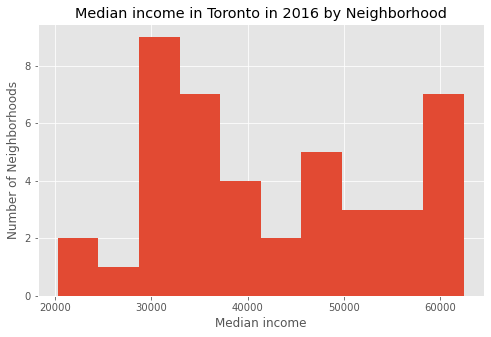

In [60]:
FullToronto['Median income'].plot(kind='hist', figsize=(8, 5))

plt.title('Median income in Toronto in 2016 by Neighborhood') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Median income') # add x-label

plt.show()

Most areas register an average income between 30.000 and 40.000, but there are quite a few showing a higher average income, between 50.000 and 60.000.

We now plot the average income against the number if venues. Each point represents a neighbouhood. There does not seem to be a clear relation between income and number of venues. Computing explicitly the correlation, we check that the two values are incorrelated. The same holds for the median income and the number of Coffee Shops.

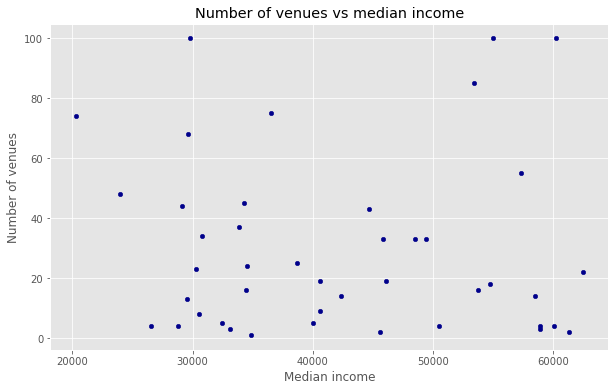

In [61]:
FullToronto.plot(kind='scatter', x='Median income', y='Number of venues', figsize=(10, 6), color='darkblue')

plt.title('Number of venues vs median income')
plt.xlabel('Median income')
plt.ylabel('Number of venues')

plt.show()

In [74]:
FullToronto[['Median income', 'Number of venues']].corr()

,Median income,Number of venues
Median income,1.000000,-0.050499
Number of venues,-0.050499,1.000000


In [73]:
NT = pd.merge(Toronto_numbers, FullToronto, how='outer', on=['Postal Code'])
NT[['Postal Code', 'Number of Coffee shops', 'Median income']].corr()

,Number of Coffee shops,Median income
Number of Coffee shops,1.000000,-0.019253
Median income,-0.019253,1.000000


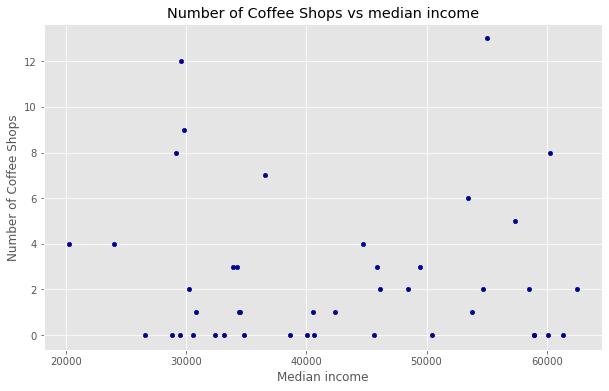

In [75]:
NT.plot(kind='scatter', x='Median income', y='Number of Coffee shops', figsize=(10, 6), color='darkblue')

plt.title('Number of Coffee Shops vs median income')
plt.xlabel('Median income')
plt.ylabel('Number of Coffee Shops')

plt.show()

We now check the correlations between the cathegories of venues we had created. In particular, we are interested in the correlation between the number of Coffee Shops and the other variables.

In [76]:
Toronto_corr = Toronto_numbers.corr()
Toronto_corr

,Number of venues,Number of Coffee shops,Number of Cafés,Total Bar-Pub,Number of Breakfast places,Total Restaurants,Total dessert,Number of Hotel,Number of Art and Touristic places,Number of Parks
Number of venues,1.000000,0.897712,0.797993,0.792110,0.309988,0.932251,0.452633,0.798992,0.686026,0.165851
Number of Coffee shops,0.897712,1.000000,0.679196,0.630347,0.271065,0.779615,0.456652,0.804377,0.745104,0.216403
Number of Cafés,0.797993,0.679196,1.000000,0.651833,0.216445,0.735544,0.328340,0.545578,0.489597,0.143407
Total Bar-Pub,0.792110,0.630347,0.651833,1.000000,0.315186,0.826885,0.331462,0.603063,0.549562,0.125861
Number of Breakfast places,0.309988,0.271065,0.216445,0.315186,1.000000,0.235222,0.010675,0.326990,0.234737,-0.067691
Total Restaurants,0.932251,0.779615,0.735544,0.826885,0.235222,1.000000,0.453710,0.647077,0.451986,0.078045
Total dessert,0.452633,0.456652,0.328340,0.331462,0.010675,0.453710,1.000000,0.140898,0.206389,0.066675
Number of Hotel,0.798992,0.804377,0.545578,0.603063,0.326990,0.647077,0.140898,1.000000,0.865090,0.139139
Number of Art and Touristic places,0.686026,0.745104,0.489597,0.549562,0.234737,0.451986,0.206389,0.865090,1.000000,0.228697
Number of Parks,0.165851,0.216403,0.143407,0.125861,-0.067691,0.078045,0.066675,0.139139,0.228697,1.000000


In [77]:
Toronto_numbers.describe()

,Number of venues,Number of Coffee shops,Number of Cafés,Total Bar-Pub,Number of Breakfast places,Total Restaurants,Total dessert,Number of Hotel,Number of Art and Touristic places,Number of Parks
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,29.953488,2.558140,1.465116,1.976744,0.348837,8.302326,0.581395,0.395349,1.348837,0.906977
std,29.250929,3.325961,1.695215,2.595677,0.650411,9.565650,0.956993,0.903420,2.926754,0.867782
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,1.000000,1.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000
75%,43.500000,3.500000,3.000000,2.500000,0.500000,13.000000,1.000000,0.000000,1.000000,1.000000
max,100.000000,13.000000,5.000000,9.000000,2.000000,32.000000,4.000000,4.000000,17.000000,3.000000


In [78]:
Toronto_corr['Number of Coffee shops']

Number of venues                      0.897712
Number of Coffee shops                1.000000
Number of Cafés                       0.679196
Total Bar-Pub                         0.630347
Number of Breakfast places            0.271065
Total Restaurants                     0.779615
Total dessert                         0.456652
Number of Hotel                       0.804377
Number of Art and Touristic places    0.745104
Number of Parks                       0.216403
Name: Number of Coffee shops, dtype: float64

### Neighborhoods ratings   <a class="anchor" id="Neighborhoos_ratings"></a> 

In [108]:
adversion = 1 #competition adversion rate

coffee_corr = Toronto_corr['Number of Coffee shops']
coffee_corr[1]=-adversion
coffee_corr.drop(['Number of Breakfast places', 'Total dessert', 'Number of Parks',], inplace=True)
coffee_corr

Number of venues                      0.897712
Number of Coffee shops               -1.000000
Number of Cafés                       0.679196
Total Bar-Pub                         0.630347
Total Restaurants                     0.779615
Number of Hotel                       0.804377
Number of Art and Touristic places    0.745104
Name: Number of Coffee shops, dtype: float64

Looking at the correlations between the number of Coffee shops and other venues, we see that the number of Coffee shops has a relevant (more than 0.5) positive correlated with the *total number of venues*, the *number of Cafés*, *Bars* and especially *Restaurants*, *Hotels* and *Art-related attractions*. A high number of those venues in a Neighborhood should indicate an area where there could be a demand for Coffee shops and where our venue could find an interesting flow of costumers.

However, the most suitable Neighborhood would also have a low number of already implanted Coffée shops. This is modeled introducing the **competition adversion index**, which can be tuned to fit the owner adversion to a strong competition in the proximity of his new venue. The higher the index value, the more fearful of competition is the owner. A value of zero means indifference to the presence of other Coffee Shops, and a negative value would mean that the owner actually considers beneficial the presence of other Coffee Shops in the vicinity. This index will sobstitute the correlation index for Coffee Shops.


Based on the above discussion, we will produce ratings for the neighborhoods of Toronto, based on the presence of venues indicating an area suitable for the installation of a Coffee shop and the number of Coffee shops already installed. We shall weight the relative number of venues in every Neighborhood and the relative total number of venues with the correlations found, using a negative value, the *competition adversion index* we indroduced above, instead of 1 for Coffee shops.

In [79]:
Toronto_per.columns

Index(['Postal Code', 'Number of venues', 'Perc Coffee shops',
       'Perc Cafés shops', 'Perc Bar-Pub', 'Perc Breakfast', 'Perc Restaurant',
       'Perc dessert', 'Perc Hotels', 'Perc Art', 'Perc Park'],
      dtype='object')

In [109]:
#prepare the percentages matrix
Toronto_per_rat = pd.DataFrame(data=Toronto_per[['Postal Code', 'Number of venues', 'Perc Coffee shops', 'Perc Cafés shops', 'Perc Bar-Pub', 'Perc Restaurant', 'Perc Hotels', 'Perc Art']])
Toronto_per_rat.rename(columns={'Perc Coffee shops':'Coffee', 'Perc Cafés shops':'Café', 'Perc Bar-Pub':'Bar', 'Perc Restaurant':'Restaurant', 'Perc Hotels':'Hotel', 'Perc Art':'Art'}, inplace=True) #, axis=1)
Toronto_per_rat.set_index('Postal Code', inplace=True)
Toronto_per_rat.head(10)

,Number of venues,Coffee,Café,Bar,Restaurant,Hotel,Art
Postal Code,,,,,,,
M4C,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M4E,0.003106,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
M4G,0.025621,0.090909,0.000000,0.030303,0.212121,0.000000,0.000000
M4H,0.018634,0.041667,0.000000,0.000000,0.250000,0.000000,0.000000
M4J,0.002329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M4K,0.033385,0.093023,0.023256,0.046512,0.372093,0.000000,0.000000
M4L,0.014752,0.052632,0.000000,0.052632,0.315789,0.000000,0.052632
M4M,0.028727,0.081081,0.054054,0.081081,0.324324,0.000000,0.000000
M4N,0.002329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [82]:
Toronto_per_rat.shape

(43, 7)

In [110]:
coffee_corr_rat = pd.DataFrame(data = coffee_corr)
coffee_corr_rat.rename(index={'Number of Coffee shops':'Coffee', 'Number of Cafés':'Café', 'Total Bar-Pub':'Bar', 'Total Restaurants':'Restaurant', 'Number of Hotel':'Hotel', 'Number of Art and Touristic places':'Art' }, inplace=True)
coffee_corr_rat

,Number of Coffee shops
Number of venues,0.897712
Coffee,-1.000000
Café,0.679196
Bar,0.630347
Restaurant,0.779615
Hotel,0.804377
Art,0.745104


In [111]:
Toronto_ratings = Toronto_per_rat.dot(coffee_corr_rat) #coffee_corr_rat.dot(Toronto_per_rat)
Toronto_ratings.rename({'Number of Coffee shops':'Neighborhood rating'}, axis=1, inplace=True)
Toronto_ratings

,Neighborhood rating
Postal Code,
M4C,0.005576
M4E,0.160375
M4G,0.116566
M4H,0.169965
M4J,0.002091
...,...
M6N,0.002788
M6P,0.463838
M6R,0.259323


We have obtained here the ratings for every area in Toronto! We can check their basic statistical characteristics, and use them to order the Neighborhoods according to their suitability.

In [112]:
Toronto_ratings.describe()

,Neighborhood rating
count,43.000000
mean,0.209915
std,0.142455
min,0.000697
25%,0.095695
50%,0.239805
75%,0.320849
max,0.463838


In [113]:
FullToronto2 = pd.merge(FullToronto, Toronto_ratings, how='outer', on=['Postal Code'])

In [114]:
FullToronto2.sort_values('Neighborhood rating', axis=0, ascending=False, inplace=True)
FullToronto2.head(10)

,Postal Code,Median income,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Number of venues,Neighborhood rating
39,M6P,38670,West Toronto,"High Park, The Junction South",43.661608,-79.464763,Mexican Restaurant,Café,Bar,Thai Restaurant,Speakeasy,Bakery,Diner,25,0.463838
19,M5C,53420,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Café,Restaurant,Cocktail Bar,Beer Bar,Gastropub,American Restaurant,85,0.442843
36,M6J,34260,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,Bar,Coffee Shop,Restaurant,Asian Restaurant,Vietnamese Restaurant,Café,Men's Store,45,0.420575
16,M4Y,36530,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Bubble Tea Shop,Hotel,75,0.395464
29,M5T,20270,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,Bar,Café,Coffee Shop,Mexican Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bakery,74,0.375834
25,M5N,45600,Central Toronto,Roselawn,43.711695,-79.416936,Music Venue,Garden,Null,Null,Null,Null,Null,2,0.373946
28,M5S,30800,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,Café,Bookstore,Bar,Japanese Restaurant,Sandwich Place,Bakery,French Restaurant,34,0.373679
20,M5E,57340,Downtown Toronto,Berczy Park,43.644771,-79.373306,Coffee Shop,Cheese Shop,Farmers Market,Bakery,Seafood Restaurant,Restaurant,Beer Bar,55,0.355214
22,M5H,60250,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Coffee Shop,Café,Restaurant,Gym,Hotel,Clothing Store,Bar,100,0.342305
41,M6S,49460,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,Café,Coffee Shop,Sushi Restaurant,Pub,Pizza Place,Italian Restaurant,Gym,33,0.333591


## Results     <a class="anchor" id="Viz"></a>

We have shown that the median income of the area most likely will not influence the presence of costumers. We have produced way to sort the neighborhoods in Toronto according to various criteria, and which can be tuned to take into account the level of adversion to competition of the owner. To ease the owner's choice, we present the results together with the list, for every area, of the most common venues, the average income, total number of venues and the names of the neighborhoods.

## Discussion  <a class="anchor" id="discussion"></a>

Considering an average reasonable competition adversion index of 1, we obtain 3 interesting candidate areas where the owner could try to set his new business: one in Downtown Toronto (*St James Town*), and interestingly two in West Toronto (*High Park* and Little Portugal - Trinity*). 

The area in Downtown Toronto is certainly more active (as much as 85 venues present in Foursquare's database) and is a wealthier area, which is a positive point for the owner. However, he should expect a more fierce competition there, as he can see that Coffee Shops are already the most common venue in the area.

On the other hand, the two spots in West Toronto are reasonably active, and even though less wealthy, they have fewer Coffee Shops already implanted.

## Conclusion <a class="anchor" id="conclusion"></a> 

Leveraging on the use of a model based on the study of correlations between different kinds of venues, this Notebook provides a comprehensive approach to chosing the best spot where to open a new Coffee Shop in Toronto, taking into account socio-economic elements, the presence of different venues which indicates a suitable environment for a Coffee Shop, and Coffeee Shops already present. It also allows for the stakeholder to tune in his own level of adversion to competition.

The flexibility of this approach makes it is easy to generalize to other venues and cities. Moreover, since the model can learn which are the most suitable areas from other kinds of venues, it has the ability to single out suitable areas for the new venue that may not have been identified by the market yet (no or very few venues of that kind already installed)!